# Figure 5 - Fast vs slow myocyte DE

In [1]:
import scanpy as sc
import pandas as pd
import pickle
import numpy as np
import plotnine as p9
import fisher
import sys
from tqdm.auto import tqdm

In [2]:
from pathlib import Path

sys.path.append(str(Path.home() / 'Code/sctoolkit'))

In [3]:
from sctoolkit.revigo import enrich_and_simplify, plot_revigo, revigo
from sctoolkit.mgsa import mgsa, plot_mgsa, plot_mgsa_diagnostics, get_go_gaf
from sctoolkit.utils import sort_by_correlation

In [4]:
sc.set_figure_params(dpi=100)
sc.settings.figdir = 'figures/'

## Read data

In [423]:
adata = sc.read('adata.h5ad')
mu = adata[adata.obs.tissue == 'skeletalmuscle'].copy()
mu = mu.raw.to_adata()
sc.pp.normalize_total(mu, target_sum=10_000)
sc.pp.log1p(mu)
mu

AnnData object with n_obs × n_vars = 30877 × 33694
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Container', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Age', 'BMI', 'Race/Ethnicity', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'batch_triplet', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'ischemic_time', 'Participant_ID', 'Sample_ID'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'S

In [424]:
mu.obs['Granular cell type'].cat.categories

Index(['Adipocyte', 'Endothelial cell (lymphatic)',
       'Endothelial cell (vascular) I', 'Endothelial cell (vascular) II',
       'Endothelial cell (vascular) III', 'Fibroblast', 'Immune (DC)',
       'Immune (DC/macrophage)', 'Immune (NK cell)', 'Immune (T cell)',
       'Immune (macrophage)', 'Immune (mast cell)', 'Immune (neutrophil)',
       'Myocyte (NMJ-rich)', 'Myocyte (fast-twitch)',
       'Myocyte (fast-twitch, cytoplasmic)', 'Myocyte (sk. muscle)',
       'Myocyte (slow-twitch, cytoplasmic)', 'Pericyte/SMC I',
       'Pericyte/SMC II', 'Satellite cell', 'Schwann cell'],
      dtype='object')

In [496]:
mu_cyto = mu[mu.obs['Granular cell type'].isin(['Myocyte (fast-twitch, cytoplasmic)','Myocyte (slow-twitch, cytoplasmic)'])].copy()
mu_cyto

AnnData object with n_obs × n_vars = 786 × 33694
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Container', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Age', 'BMI', 'Race/Ethnicity', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'batch_triplet', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'ischemic_time', 'Participant_ID', 'Sample_ID'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Str

In [497]:
muscle_diseases = pd.read_feather('../../Figure 4/preprocessing-muscle-diseases/musclediseasegenes-processed.feather')
muscle_diseases = muscle_diseases[muscle_diseases['Disease group']!='Hereditary cardiomyopathies']
muscle_diseases.head()

,Disease group,Disease subgroup,Disease phenotype,Gene,Item,Gene symbol (chromosome) protein,Disease group subgroup,disease_id,disease_cat,disease_gene,disease_group_gene,disease_group_subgroup_gene
0,Muscular dystrophies,Dmd,Duchenne/Becker Muscular Dystrophies - (XR),DMD,1.1,DMD (Xp21.2) Dystrophin,Muscular dystrophies (DMD),Muscular dystrophies-DMD-Duchenne/becker muscu...,Muscular dystrophies-DMD,Duchenne/Becker Muscular Dystrophies - (XR)-DMD,Muscular dystrophies|DMD,Muscular dystrophies (DMD)|DMD
1,Muscular dystrophies,Edmd,"Emery-Dreifuss muscular dystrophy, X-linked , ...",EMD,1.2,EMD (Xq28) Emerin,Muscular dystrophies (EDMD),Muscular dystrophies-EDMD-Emery-dreifuss muscu...,Muscular dystrophies-EDMD,"Emery-Dreifuss muscular dystrophy, X-linked , ...",Muscular dystrophies|EMD,Muscular dystrophies (EDMD)|EMD
2,Muscular dystrophies,Edmd,"Emery-Dreifuss muscular dystrophy 6, X-linked ...",FHL1,1.3,FHL1 (Xq26.3) Four and a half LIM domain 1,Muscular dystrophies (EDMD),Muscular dystrophies-EDMD-Emery-dreifuss muscu...,Muscular dystrophies-EDMD,"Emery-Dreifuss muscular dystrophy 6, X-linked ...",Muscular dystrophies|FHL1,Muscular dystrophies (EDMD)|FHL1
3,Muscular dystrophies,Edmd,"Emery-Dreifuss muscular dystrophy 2, autosomal...",LMNA,1.4,LMNA (1q22) Lamin A/C,Muscular dystrophies (EDMD),Muscular dystrophies-EDMD-Emery-dreifuss muscu...,Muscular dystrophies-EDMD,"Emery-Dreifuss muscular dystrophy 2, autosomal...",Muscular dystrophies|LMNA,Muscular dystrophies (EDMD)|LMNA
4,Muscular dystrophies,Edmd,"Emery-Dreifuss muscular dystrophy 3, autosomal...",LMNA,1.5,LMNA (1q22) Lamin A/C,Muscular dystrophies (EDMD),Muscular dystrophies-EDMD-Emery-dreifuss muscu...,Muscular dystrophies-EDMD,"Emery-Dreifuss muscular dystrophy 3, autosomal...",Muscular dystrophies|LMNA,Muscular dystrophies (EDMD)|LMNA


In [498]:
muscle_disease_groups = muscle_diseases.groupby('Gene')['Disease group'].agg(lambda x: ','.join(sorted(x.unique()))).reset_index()
muscle_disease_groups

,Gene,Disease group
0,78,Hereditary motor and sensory neuropathies
1,AARS,"Hereditary motor and sensory neuropathies,Moto..."
2,ABHD5,Metabolic myopathies
3,ACAD9,Metabolic myopathies
4,ACADVL,Metabolic myopathies
...,...,...
521,YARS2,Other neuromuscular disorders
522,ZBTB42,Motor neuron diseases
523,ZFHX2,Hereditary motor and sensory neuropathies
524,ZFYVE26,Hereditary paraplegias


In [499]:
mus_genes = mu_cyto.var_names[mu_cyto.var_names.isin(muscle_diseases.Gene.unique())].tolist()

In [500]:
mu_cyto = mu_cyto[:, mus_genes].copy()
mu_cyto

AnnData object with n_obs × n_vars = 786 × 512
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Container', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Age', 'BMI', 'Race/Ethnicity', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'batch_triplet', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'ischemic_time', 'Participant_ID', 'Sample_ID'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Stran

## Rubenstein et al markers

In [502]:
myocyte_markers = {
    'Slow myocytes': ['ANKRD2', 'MYL6B', 'MYH7', 'TNNI1', 'TPM3', 'MYL3', 'TNNT1', 'PDLIM1', 'CYB5R1', 'TNNC1', 'MYL2', 'ATP2A2', 'CASQ2', 'LDHB', 'MYOZ2', 'FABP3', 'CD36', 'PLN'],
    'Fast myocytes': ['G0S2', 'PKM', 'DDIT4L', 'PFKM', 'LDHA', 'ENO3', 'ALDOA', 'GAPDH', 'MYH2', 'TPM1', 'MYLPF', 'TNNC2', 'TNNI2', 'TNNT3', 'ATP2A1', 'MYBPC2', 'PGM1', 'SLN', 'MYH1']
}

myocyte_markers = pd.DataFrame.from_dict({'names': myocyte_markers}).explode('names').reset_index().rename(columns={'index': 'marker_group'})
myocyte_markers.head()

,marker_group,names
0,Fast myocytes,G0S2
1,Fast myocytes,PKM
2,Fast myocytes,DDIT4L
3,Fast myocytes,PFKM
4,Fast myocytes,LDHA


## DE

In [503]:
sc.tl.rank_genes_groups(mu_cyto, 'Granular cell type')

In [531]:
de = sc.get.rank_genes_groups_df(mu_cyto, group='Myocyte (fast-twitch, cytoplasmic)')
de.head()

,names,scores,logfoldchanges,pvals,pvals_adj
0,TNNT3,20.550184,5.207453,1.930390e-50,9.883598e-48
1,TNNI2,17.428328,4.516328,2.852416e-41,7.302185e-39
2,MYH2,12.492931,3.934646,8.486372e-26,1.086256e-23
3,ENO3,9.714817,1.995095,9.402983e-19,6.017909e-17
4,ATP2A1,9.555996,2.821893,1.353859e-17,7.701952e-16


In [532]:
de = de.merge(muscle_disease_groups, left_on='names', right_on='Gene', how='left').rename(columns={'Disease group': 'disease_group'})
de

,names,scores,logfoldchanges,pvals,pvals_adj,Gene,disease_group
0,TNNT3,20.550184,5.207453,1.930390e-50,9.883598e-48,TNNT3,Other neuromuscular disorders
1,TNNI2,17.428328,4.516328,2.852416e-41,7.302185e-39,TNNI2,Other neuromuscular disorders
2,MYH2,12.492931,3.934646,8.486372e-26,1.086256e-23,MYH2,Congenital myopathies
3,ENO3,9.714817,1.995095,9.402983e-19,6.017909e-17,ENO3,Metabolic myopathies
4,ATP2A1,9.555996,2.821893,1.353859e-17,7.701952e-16,ATP2A1,Myotonic syndromes
...,...,...,...,...,...,...,...
507,GBE1,-7.897561,-2.238763,6.651125e-14,3.405376e-12,GBE1,Metabolic myopathies
508,MYL2,-10.479360,-3.210643,4.914501e-21,3.594607e-19,MYL2,Congenital myopathies
509,MYH7,-11.488720,-3.338449,2.177881e-23,1.858458e-21,MYH7,"Congenital myopathies,Distal myopathies"
510,TNNT1,-11.833300,-3.363738,3.796811e-24,3.887934e-22,TNNT1,Congenital myopathies


In [536]:
de = de[de.logfoldchanges>-10]
de = de[de.logfoldchanges<10]

In [537]:
de['neglog_pval_adj'] = -np.log10(de.pvals_adj)
de['neglog_pval_adj'][de['neglog_pval_adj']>50] = 50
de['significant'] = (de.pvals_adj<0.05) & (de.logfoldchanges.abs()>0.5)
de['gene_type'] = ['Fast myocytes' if x>0 else 'Slow myocytes' for x in de.logfoldchanges]
de['disease_group_split'] = [x.split(',') for x in de.disease_group]

xlimit = de.logfoldchanges.abs().max()

/tmp/ipykernel_142503/297217148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [538]:
len(de.names.unique())

414

In [539]:
import fisher

for g in de.disease_group_split.explode().unique():
    df = pd.DataFrame({
        'disease_group': [g in x for x in de.disease_group_split],
        'gene_type': (de.gene_type == 'Fast myocytes') & (de.significant),
    })

    d = pd.crosstab(df.disease_group, df.gene_type)
    p = fisher.pvalue(*d.values.flatten()).right_tail
    if p<=0.05:
        display(de[df.disease_group & df.gene_type])        
        print(g)        
        print('\t', p)

,names,scores,logfoldchanges,pvals,pvals_adj,Gene,disease_group,neglog_pval_adj,significant,gene_type,disease_group_split
2,MYH2,12.492931,3.934646,8.486372e-26,1.086256e-23,MYH2,Congenital myopathies,22.964068,True,Fast myocytes,[Congenital myopathies]
6,ACTA1,5.174409,1.242463,4.939457e-07,1.264501e-05,ACTA1,"Congenital muscular dystrophies,Congenital myo...",4.898081,True,Fast myocytes,"[Congenital muscular dystrophies, Congenital m..."
7,MYL1,5.114652,1.596448,7.793785e-07,1.900199e-05,MYL1,Congenital myopathies,4.721201,True,Fast myocytes,[Congenital myopathies]
8,TPM2,3.961593,0.970275,1.018321e-04,1.448279e-03,TPM2,"Congenital myopathies,Other neuromuscular diso...",2.839148,True,Fast myocytes,"[Congenital myopathies, Other neuromuscular di..."


Congenital myopathies
	 0.01250815725831601


In [540]:
import fisher

ps = {}

for g in de.disease_group_split.explode().unique():
    df = pd.DataFrame({
        'disease_group': [g in x for x in de.disease_group_split],
        'gene_type': (de.gene_type == 'Slow myocytes') & (de.significant),
    })

    d = pd.crosstab(df.disease_group, df.gene_type)
    p = fisher.pvalue(*d.values.flatten()).right_tail
    ps[g] = p
    if p<=0.05:
        display(de[df.disease_group & df.gene_type])
        print(g)        
        print('\t', p)

,names,scores,logfoldchanges,pvals,pvals_adj,Gene,disease_group,neglog_pval_adj,significant,gene_type,disease_group_split
426,ACTN2,-2.646295,-0.681014,8.804807e-03,4.647486e-02,ACTN2,"Congenital myopathies,Distal myopathies",1.332782,True,Slow myocytes,"[Congenital myopathies, Distal myopathies]"
432,CACNA1S,-2.723852,-1.525901,6.773018e-03,3.769332e-02,CACNA1S,"Congenital myopathies,Ion channel muscle disea...",1.423736,True,Slow myocytes,"[Congenital myopathies, Ion channel muscle dis..."
466,HACD1,-3.219089,-1.415204,1.446479e-03,1.276891e-02,HACD1,Congenital myopathies,1.893846,True,Slow myocytes,[Congenital myopathies]
493,RYR3,-4.507894,-2.178571,8.609272e-06,1.695364e-04,RYR3,Congenital myopathies,3.770737,True,Slow myocytes,[Congenital myopathies]
498,MYPN,-5.048676,-1.525384,8.425929e-07,1.960943e-05,MYPN,Congenital myopathies,4.707535,True,Slow myocytes,[Congenital myopathies]
508,MYL2,-10.479360,-3.210643,4.914501e-21,3.594607e-19,MYL2,Congenital myopathies,18.444349,True,Slow myocytes,[Congenital myopathies]
509,MYH7,-11.488720,-3.338449,2.177881e-23,1.858458e-21,MYH7,"Congenital myopathies,Distal myopathies",20.730847,True,Slow myocytes,"[Congenital myopathies, Distal myopathies]"
510,TNNT1,-11.833300,-3.363738,3.796811e-24,3.887934e-22,TNNT1,Congenital myopathies,21.410281,True,Slow myocytes,[Congenital myopathies]
511,TPM3,-12.722880,-3.377928,1.883045e-27,3.213731e-25,TPM3,Congenital myopathies,24.492990,True,Slow myocytes,[Congenital myopathies]


Congenital myopathies
	 0.023952151862822048


,names,scores,logfoldchanges,pvals,pvals_adj,Gene,disease_group,neglog_pval_adj,significant,gene_type,disease_group_split
425,RBCK1,-2.612087,-1.836827,9.348797e-03,4.884270e-02,RBCK1,Metabolic myopathies,1.311200,True,Slow myocytes,[Metabolic myopathies]
454,PRKAG2,-3.031646,-1.465612,2.655230e-03,1.942111e-02,PRKAG2,Metabolic myopathies,1.711726,True,Slow myocytes,[Metabolic myopathies]
464,SLC16A1,-3.178046,-2.559050,1.572612e-03,1.364707e-02,SLC16A1,Metabolic myopathies,1.864961,True,Slow myocytes,[Metabolic myopathies]
468,ETFA,-3.273915,-1.022638,1.224148e-03,1.160674e-02,ETFA,Metabolic myopathies,1.935290,True,Slow myocytes,[Metabolic myopathies]
472,SLC22A5,-3.349324,-1.236661,9.428995e-04,9.465972e-03,SLC22A5,Metabolic myopathies,2.023835,True,Slow myocytes,[Metabolic myopathies]
503,SLC25A20,-6.049837,-3.793986,2.295387e-09,8.394558e-08,SLC25A20,Metabolic myopathies,7.076002,True,Slow myocytes,[Metabolic myopathies]
504,ETFDH,-6.083131,-3.070827,2.215777e-09,8.394558e-08,ETFDH,Metabolic myopathies,7.076002,True,Slow myocytes,[Metabolic myopathies]
507,GBE1,-7.897561,-2.238763,6.651125e-14,3.405376e-12,GBE1,Metabolic myopathies,11.467835,True,Slow myocytes,[Metabolic myopathies]


Metabolic myopathies
	 0.010529317565576787


/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 8 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figure-slow-vs-fast-A.pdf


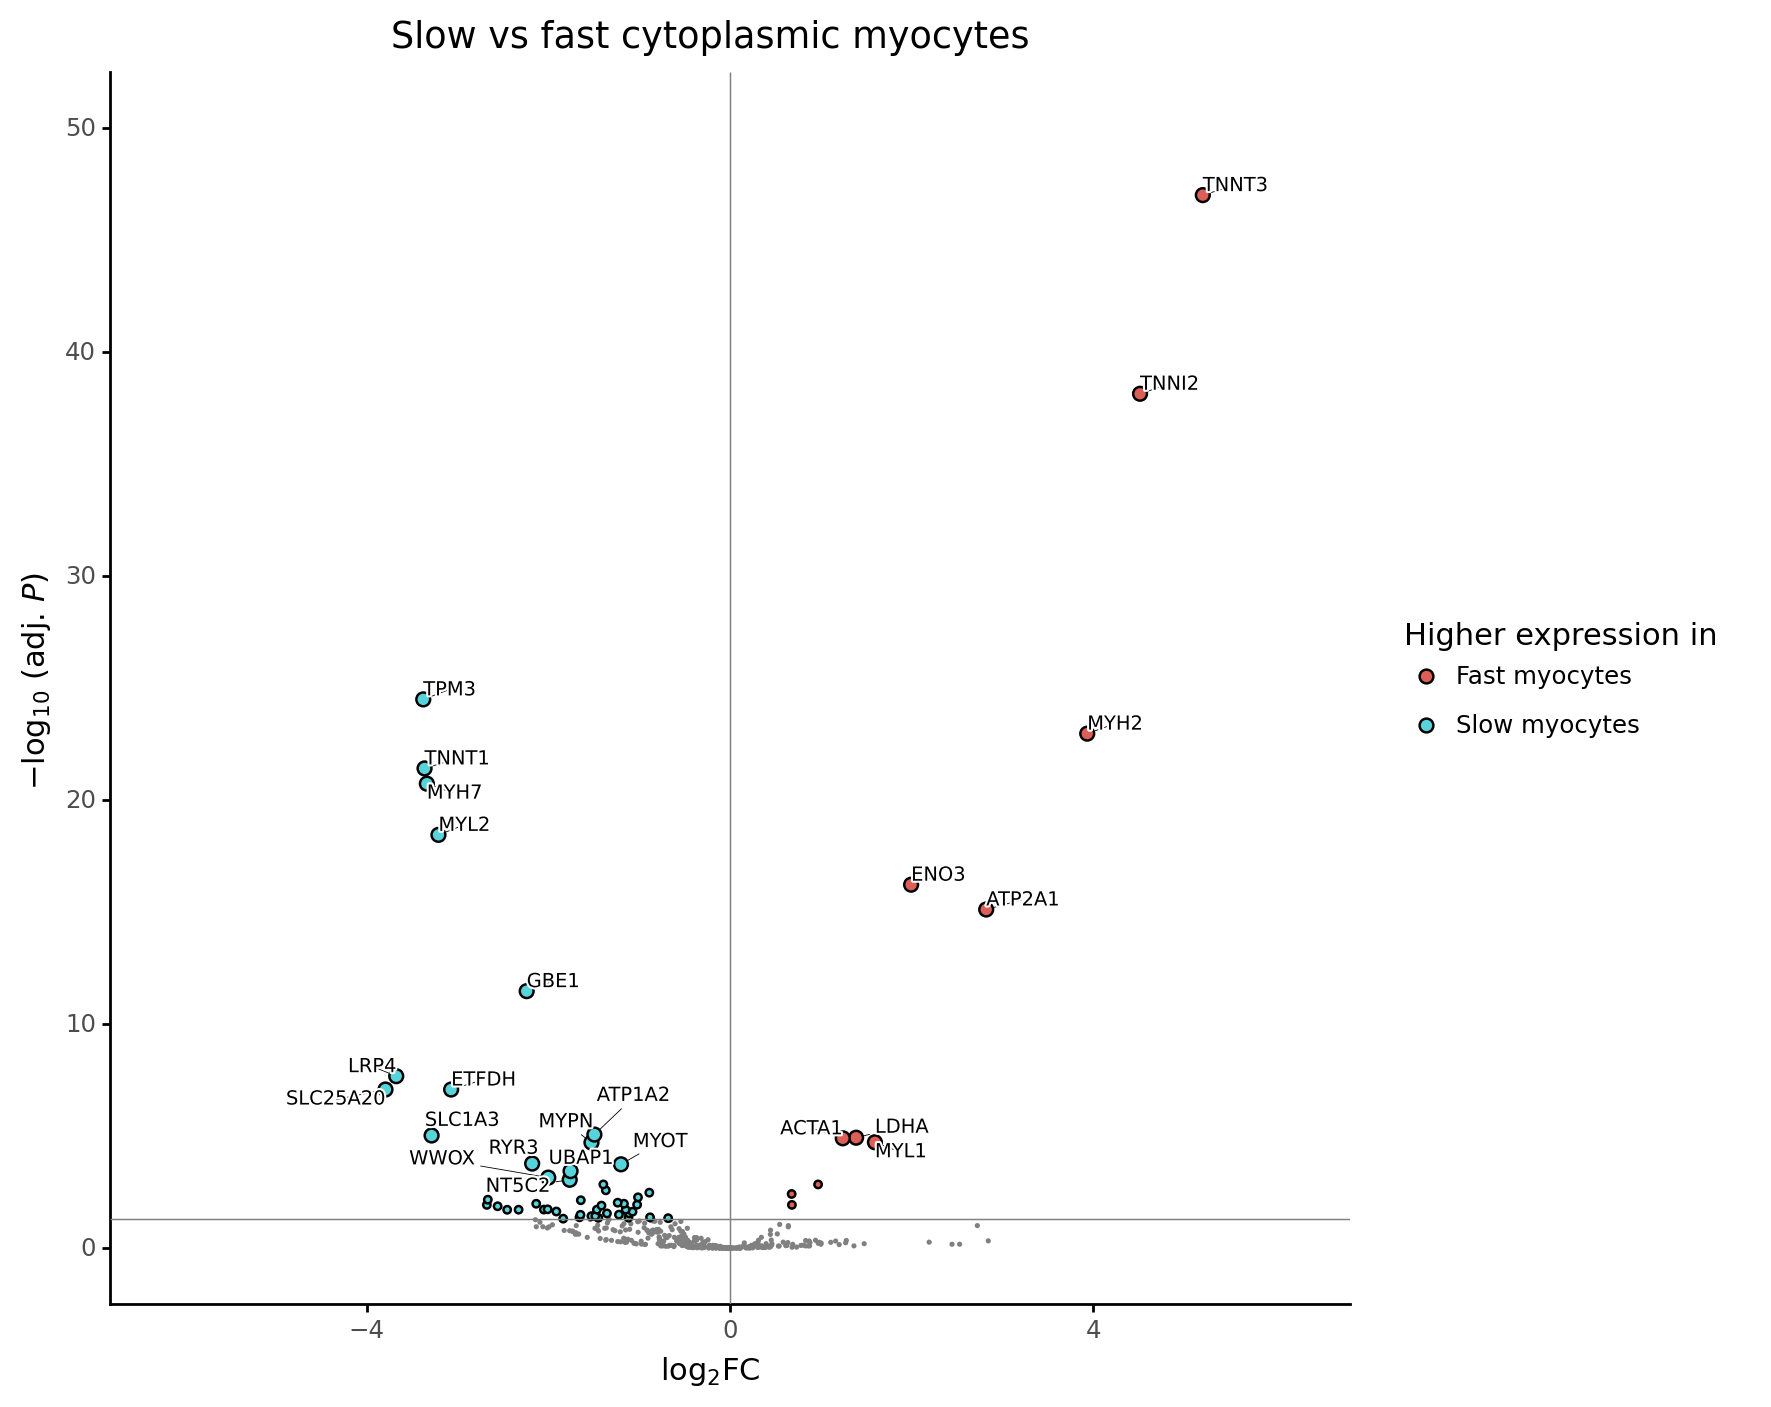

<ggplot: (8743063419670)>

In [403]:
from plotnine import *
import matplotlib.patheffects as pe

df_text_idx = de.significant & (de.neglog_pval_adj>3)
g = (
    ggplot(aes(x='logfoldchanges', y='neglog_pval_adj'), data=de[de.significant]) + 
    geom_point(size=0.05, data=de[(~de.significant)], color='gray') +    
    geom_point(aes(fill='gene_type'),size=1, data=de[de.significant&(~df_text_idx)]) +
    geom_hline(yintercept=(-np.log10(0.05)), size=0.3, color='gray') +    
    geom_vline(xintercept=0, size=0.3, color='gray') +        
    geom_point(aes(fill='gene_type'), color='black', size=2.3, data=de[de.significant&(df_text_idx)]) +        
    geom_text(aes(label='names'), size=7, color='black', fontweight='normal', data=de[df_text_idx],
              path_effects=[pe.Stroke(linewidth=1.5, foreground='white'),pe.Normal()],
              adjust_text=
              {
                  'arrowprops':{'arrowstyle': '-', 'lw':0.3}, 
                  'x':de[de.significant].logfoldchanges.values, 
                  'y':de[de.significant].neglog_pval_adj.values, 
                  'expand_points': (1,1.5),
              }
    ) + 
    theme_classic() + 
    theme(figure_size=(8,8)) +
    labs(x='$\log_{2}$FC', y='$-\log_{10}$ (adj. $P$)', fill='Higher expression in', title='Slow vs fast cytoplasmic myocytes') +
    coord_cartesian(xlim=(-xlimit-1, xlimit+1), ylim=(None, 50))+
    guides(color = guide_legend(override_aes = dict(size=5)))
)

ggsave(g, 'figure-slow-vs-fast-A.pdf')

g

In [404]:
import colorcet as cc
import seaborn as sns

glasbey_hv = sns.color_palette(cc.glasbey_hv).as_hex()

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 8 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figure-slow-vs-fast-B.pdf


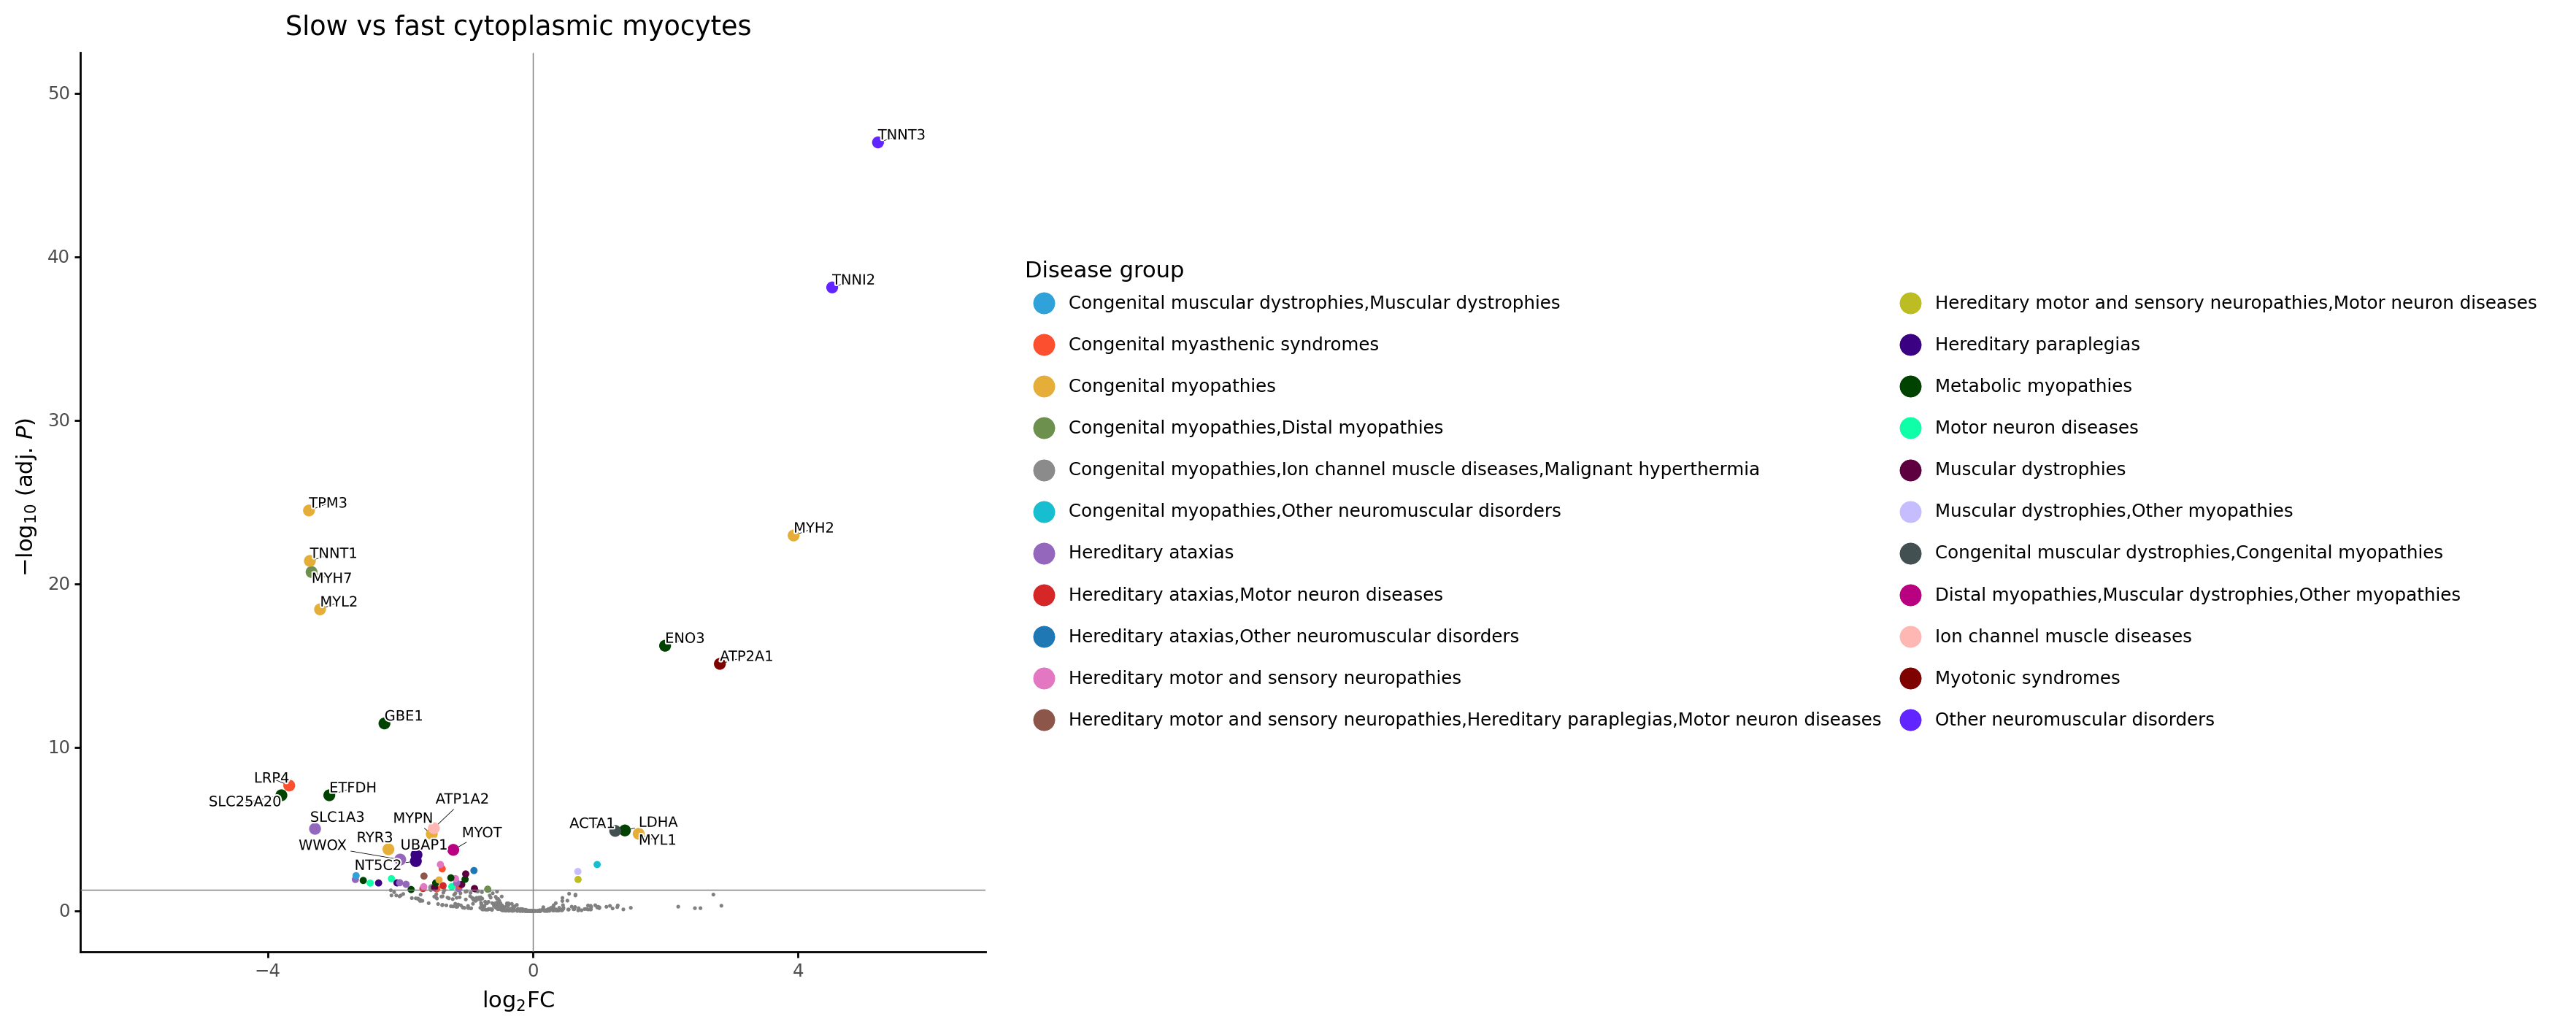

<ggplot: (8743055886312)>

In [375]:
from plotnine import *
import matplotlib.patheffects as pe

df_text_idx = de.significant & (de.neglog_pval_adj>3)
g = (
    ggplot(aes(x='logfoldchanges', y='neglog_pval_adj'), data=de[de.significant]) + 
    geom_point(size=0.05, data=de[(~de.significant)], color='gray') +    
    geom_point(aes(color='disease_group'),size=1, data=de[de.significant&(~df_text_idx)]) +
    geom_hline(yintercept=(-np.log10(0.05)), size=0.3, color='gray') +    
    geom_vline(xintercept=0, size=0.3, color='gray') +        
    geom_point(aes(color='disease_group'), size=2.3, data=de[de.significant&(df_text_idx)]) +        
    geom_text(aes(label='names'), size=7, color='black', fontweight='normal', data=de[df_text_idx],
              path_effects=[pe.Stroke(linewidth=1.5, foreground='white'),pe.Normal()],
              adjust_text=
              {
                  'arrowprops':{'arrowstyle': '-', 'lw':0.3}, 
                  'x':de[de.significant].logfoldchanges.values, 
                  'y':de[de.significant].neglog_pval_adj.values, 
                  'expand_points': (1,1.5),
              }
    ) + 
    theme_classic() + 
    scale_color_manual(glasbey_hv) +
    theme(figure_size=(8,8)) +
    labs(x='$\log_{2}$FC', y='$-\log_{10}$ (adj. $P$)', color='Disease group', title='Slow vs fast cytoplasmic myocytes') +
    coord_cartesian(xlim=(-xlimit-1, xlimit+1), ylim=(None, 50))+
    guides(color = guide_legend(override_aes = dict(size=5)))
)

ggsave(g, 'figure-slow-vs-fast-B.pdf')

g

In [376]:
de = de.merge(myocyte_markers, how='left')

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 8 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figure-slow-vs-fast-C.pdf


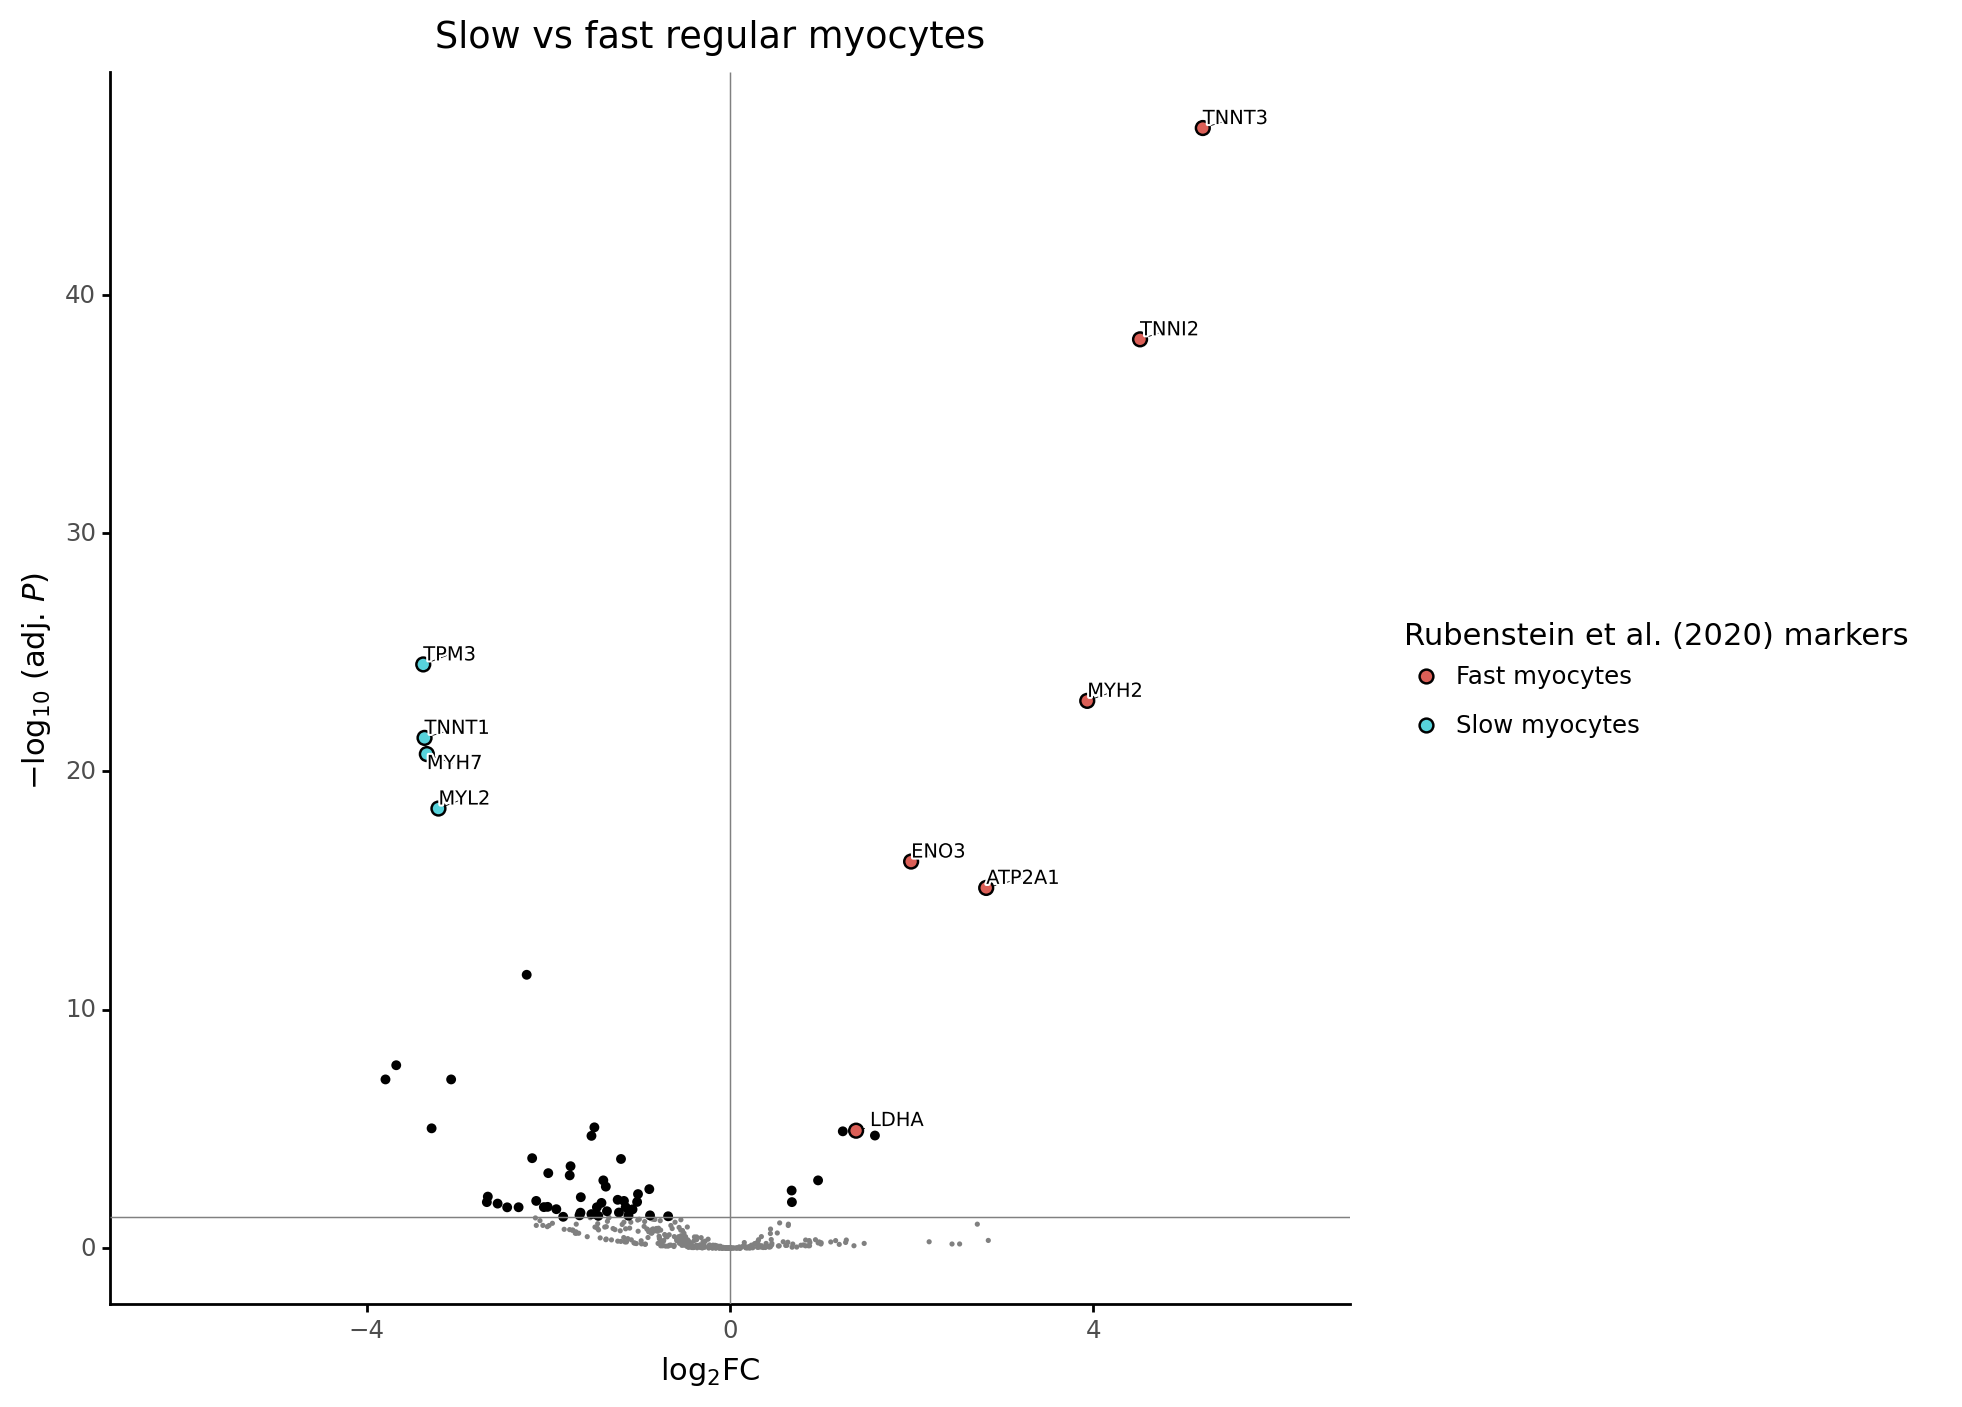

<ggplot: (8743056238059)>

In [377]:
from plotnine import *
import matplotlib.patheffects as pe

df_text_idx = de.significant & (de.marker_group.notna())
g = (
    ggplot(aes(x='logfoldchanges', y='neglog_pval_adj'), data=de[de.significant]) +     
    geom_point(size=0.05, data=de[(~de.significant)], color='gray') +    
    geom_point(size=1, data=de[de.significant&(~df_text_idx)]) +
    geom_hline(yintercept=(-np.log10(0.05)), size=0.3, color='gray') +    
    geom_vline(xintercept=0, size=0.3, color='gray') +        
    geom_point(aes(fill='marker_group'), color='black', size=2.3, data=de[de.significant&(df_text_idx)]) +    
    geom_text(aes(label='names'), size=7, color='black', fontweight='normal', data=de[df_text_idx],
              path_effects=[pe.Stroke(linewidth=1.5, foreground='white'),pe.Normal()],
              adjust_text=
              {
                  'arrowprops':{'arrowstyle': '-', 'lw':0.3}, 
                  'x':de[de.significant].logfoldchanges.values, 
                  'y':de[de.significant].neglog_pval_adj.values, 
                  'expand_points': (1,1.5),
              }
    ) + 
    theme_classic() + 
    theme(figure_size=(8,8)) +
    labs(x='$\log_{2}$FC', y='$-\log_{10}$ (adj. $P$)', fill='Rubenstein et al. (2020) markers', title='Slow vs fast cytoplasmic myocytes') +
    #scale_color_cmapd(values=ad.uns['Tissue_colors']) +
    coord_cartesian(xlim=(-xlimit-1, xlimit+1))+
    guides(color = guide_legend(override_aes = dict(size=5)))
)

ggsave(g, 'figure-slow-vs-fast-C.pdf')

g

## Regular myocytes

In [350]:
mu.obs['Granular cell type'].cat.categories

Index(['Adipocyte', 'Endothelial cell (lymphatic)',
       'Endothelial cell (vascular) I', 'Endothelial cell (vascular) II',
       'Endothelial cell (vascular) III', 'Fibroblast', 'Immune (DC)',
       'Immune (DC/macrophage)', 'Immune (NK cell)', 'Immune (T cell)',
       'Immune (macrophage)', 'Immune (mast cell)', 'Immune (neutrophil)',
       'Myocyte (NMJ-rich)', 'Myocyte (fast-twitch)',
       'Myocyte (fast-twitch, cytoplasmic)', 'Myocyte (sk. muscle)',
       'Myocyte (slow-twitch, cytoplasmic)', 'Pericyte/SMC I',
       'Pericyte/SMC II', 'Satellite cell', 'Schwann cell'],
      dtype='object')

In [436]:
mu_reg = mu[mu.obs['Granular cell type'].isin(['Myocyte (fast-twitch)','Myocyte (sk. muscle)'])].copy()
mu_reg

AnnData object with n_obs × n_vars = 20821 × 33694
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Container', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Age', 'BMI', 'Race/Ethnicity', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'batch_triplet', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'ischemic_time', 'Participant_ID', 'Sample_ID'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'S

In [437]:
mus_genes = mu_reg.var_names[mu_reg.var_names.isin(muscle_diseases.Gene.unique())].tolist()

In [438]:
mu_reg = mu_reg[:, mus_genes].copy()
mu_reg = mu_reg[:, mu_reg.X.sum(0)>0].copy()
mu_reg = mu_reg[mu_reg.X.sum(1)>0, :].copy()
mu_reg

AnnData object with n_obs × n_vars = 20821 × 497
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Container', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Age', 'BMI', 'Race/Ethnicity', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'batch_triplet', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'ischemic_time', 'Participant_ID', 'Sample_ID'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Str

In [439]:
sc.tl.rank_genes_groups(mu_reg, 'Granular cell type')

In [470]:
de = sc.get.rank_genes_groups_df(mu_reg, group='Myocyte (fast-twitch)')

In [471]:
de = de.merge(muscle_disease_groups, left_on='names', right_on='Gene', how='left').rename(columns={'Disease group': 'disease_group'})
de

,names,scores,logfoldchanges,pvals,pvals_adj,Gene,disease_group
0,ATP2A1,36.783119,3.780195,7.209479e-212,1.194370e-209,ATP2A1,Myotonic syndromes
1,TNNT3,33.909218,5.102819,1.707247e-186,1.060627e-184,TNNT3,Other neuromuscular disorders
2,MYO18B,23.358162,1.430477,1.063151e-104,5.283858e-103,MYO18B,Congenital myopathies
3,FHL1,21.069254,2.156593,8.634285e-87,3.576033e-85,FHL1,"Muscular dystrophies,Other myopathies"
4,DMD,19.331741,0.592295,1.266575e-75,4.842214e-74,DMD,Muscular dystrophies
...,...,...,...,...,...,...,...
492,CHRNA1,-32.885849,-3.380129,1.077280e-204,8.923470e-203,CHRNA1,Congenital myasthenic syndromes
493,PPARGC1A,-33.176655,-2.388358,2.574396e-191,1.827821e-189,NaN,NaN
494,GBE1,-35.598618,-2.427966,5.026296e-207,4.996138e-205,GBE1,Metabolic myopathies
495,SLC1A3,-36.056377,-4.317652,9.957586e-256,2.474460e-253,SLC1A3,Hereditary ataxias


In [380]:
de = de[de.logfoldchanges>-10]
de = de[de.logfoldchanges<10]

In [381]:
de['neglog_pval_adj'] = -np.log10(de.pvals_adj)
de['neglog_pval_adj'][de['neglog_pval_adj']>80] = 80
de['significant'] = (de.pvals_adj<0.05) & (de.logfoldchanges.abs()>1)
de['gene_type'] = ['Fast myocytes' if x>0 else 'Slow myocytes' for x in de.logfoldchanges]
de['disease_group_split'] = [x.split(',') for x in de.disease_group]

xlimit = de.logfoldchanges.abs().max()

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_142503/2355474787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [382]:
de

,names,scores,logfoldchanges,pvals,pvals_adj,Gene,disease_group,neglog_pval_adj,significant,gene_type,disease_group_split
0,ATP2A1,36.783119,3.780195,7.209479e-212,1.191967e-209,ATP2A1,Myotonic syndromes,80.000000,True,Fast myocytes,[Myotonic syndromes]
1,TNNT3,33.909218,5.102819,1.707247e-186,1.209707e-184,TNNT3,Other neuromuscular disorders,80.000000,True,Fast myocytes,[Other neuromuscular disorders]
2,MYO18B,23.358162,1.430477,1.063151e-104,5.859141e-103,MYO18B,Congenital myopathies,80.000000,True,Fast myocytes,[Congenital myopathies]
3,FHL1,21.069254,2.156593,8.634285e-87,3.893277e-85,FHL1,"Muscular dystrophies,Other myopathies",80.000000,True,Fast myocytes,"[Muscular dystrophies, Other myopathies]"
4,DMD,19.331741,0.592295,1.266575e-75,5.235177e-74,DMD,Muscular dystrophies,73.281069,False,Fast myocytes,[Muscular dystrophies]
...,...,...,...,...,...,...,...,...,...,...,...
491,TNNT1,-31.725935,-4.763609,1.207253e-208,1.496994e-206,TNNT1,Congenital myopathies,80.000000,True,Slow myocytes,[Congenital myopathies]
492,CHRNA1,-32.885849,-3.380129,1.077280e-204,8.905516e-203,CHRNA1,Congenital myasthenic syndromes,80.000000,True,Slow myocytes,[Congenital myasthenic syndromes]
493,GBE1,-35.598618,-2.427966,5.026296e-207,4.986086e-205,GBE1,Metabolic myopathies,80.000000,True,Slow myocytes,[Metabolic myopathies]
494,SLC1A3,-36.056377,-4.317652,9.957586e-256,2.469481e-253,SLC1A3,Hereditary ataxias,80.000000,True,Slow myocytes,[Hereditary ataxias]


In [383]:
len(de.names.unique())

455

In [384]:
import fisher

for g in de.disease_group_split.explode().unique():
    df = pd.DataFrame({
        'disease_group': [g in x for x in de.disease_group_split],
        'gene_type': (de.gene_type == 'Fast myocytes') & (de.significant),
    })

    d = pd.crosstab(df.disease_group, df.gene_type)
    p = fisher.pvalue(*d.values.flatten()).right_tail
    if p<=0.05:
        display(de[df.disease_group & df.gene_type])                
        print(g)        
        print('\t', p)

,names,scores,logfoldchanges,pvals,pvals_adj,Gene,disease_group,neglog_pval_adj,significant,gene_type,disease_group_split
0,ATP2A1,36.783119,3.780195,7.209479e-212,1.191967e-209,ATP2A1,Myotonic syndromes,80.00000,True,Fast myocytes,[Myotonic syndromes]
18,CNBP,7.550801,1.139567,7.360693e-14,7.158635e-13,CNBP,Myotonic syndromes,12.14517,True,Fast myocytes,[Myotonic syndromes]


Myotonic syndromes
	 0.03242187877222324


In [385]:
import fisher

for g in de.disease_group_split.explode().unique():

    df = pd.DataFrame({
        'disease_group': [g in x for x in de.disease_group_split],
        'gene_type': (de.gene_type == 'Slow myocytes') & (de.significant),
    })

    d = pd.crosstab(df.disease_group, df.gene_type)
    p = fisher.pvalue(*d.values.flatten()).right_tail
    
    if p<=0.05:
        display(de[df.disease_group & df.gene_type])        
        print(g)        
        print('\t', p)

,names,scores,logfoldchanges,pvals,pvals_adj,Gene,disease_group,neglog_pval_adj,significant,gene_type,disease_group_split
392,GMPPB,-3.382458,-2.337882,7.279394e-04,2.350904e-03,GMPPB,"Congenital muscular dystrophies,Congenital mya...",2.628765,True,Slow myocytes,"[Congenital muscular dystrophies, Congenital m..."
458,ALG14,-6.738311,-1.296111,2.099473e-11,1.826910e-10,ALG14,Congenital myasthenic syndromes,9.738283,True,Slow myocytes,[Congenital myasthenic syndromes]
461,ALG2,-7.053306,-1.957842,2.317919e-12,2.129052e-11,ALG2,Congenital myasthenic syndromes,10.671814,True,Slow myocytes,[Congenital myasthenic syndromes]
467,PREPL,-8.282958,-1.352348,2.217219e-16,2.390741e-15,PREPL,Congenital myasthenic syndromes,14.621468,True,Slow myocytes,[Congenital myasthenic syndromes]
474,COLQ,-8.967023,-1.393239,6.940429e-19,8.826802e-18,COLQ,Congenital myasthenic syndromes,17.054197,True,Slow myocytes,[Congenital myasthenic syndromes]
484,MYO9A,-13.198441,-1.010701,5.976873e-38,1.185812e-36,MYO9A,Congenital myasthenic syndromes,35.925984,True,Slow myocytes,[Congenital myasthenic syndromes]
492,CHRNA1,-32.885849,-3.380129,1.077280e-204,8.905516e-203,CHRNA1,Congenital myasthenic syndromes,80.000000,True,Slow myocytes,[Congenital myasthenic syndromes]


Congenital myasthenic syndromes
	 0.029426963122799264


/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 8 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figure-slow-vs-fast-D.pdf


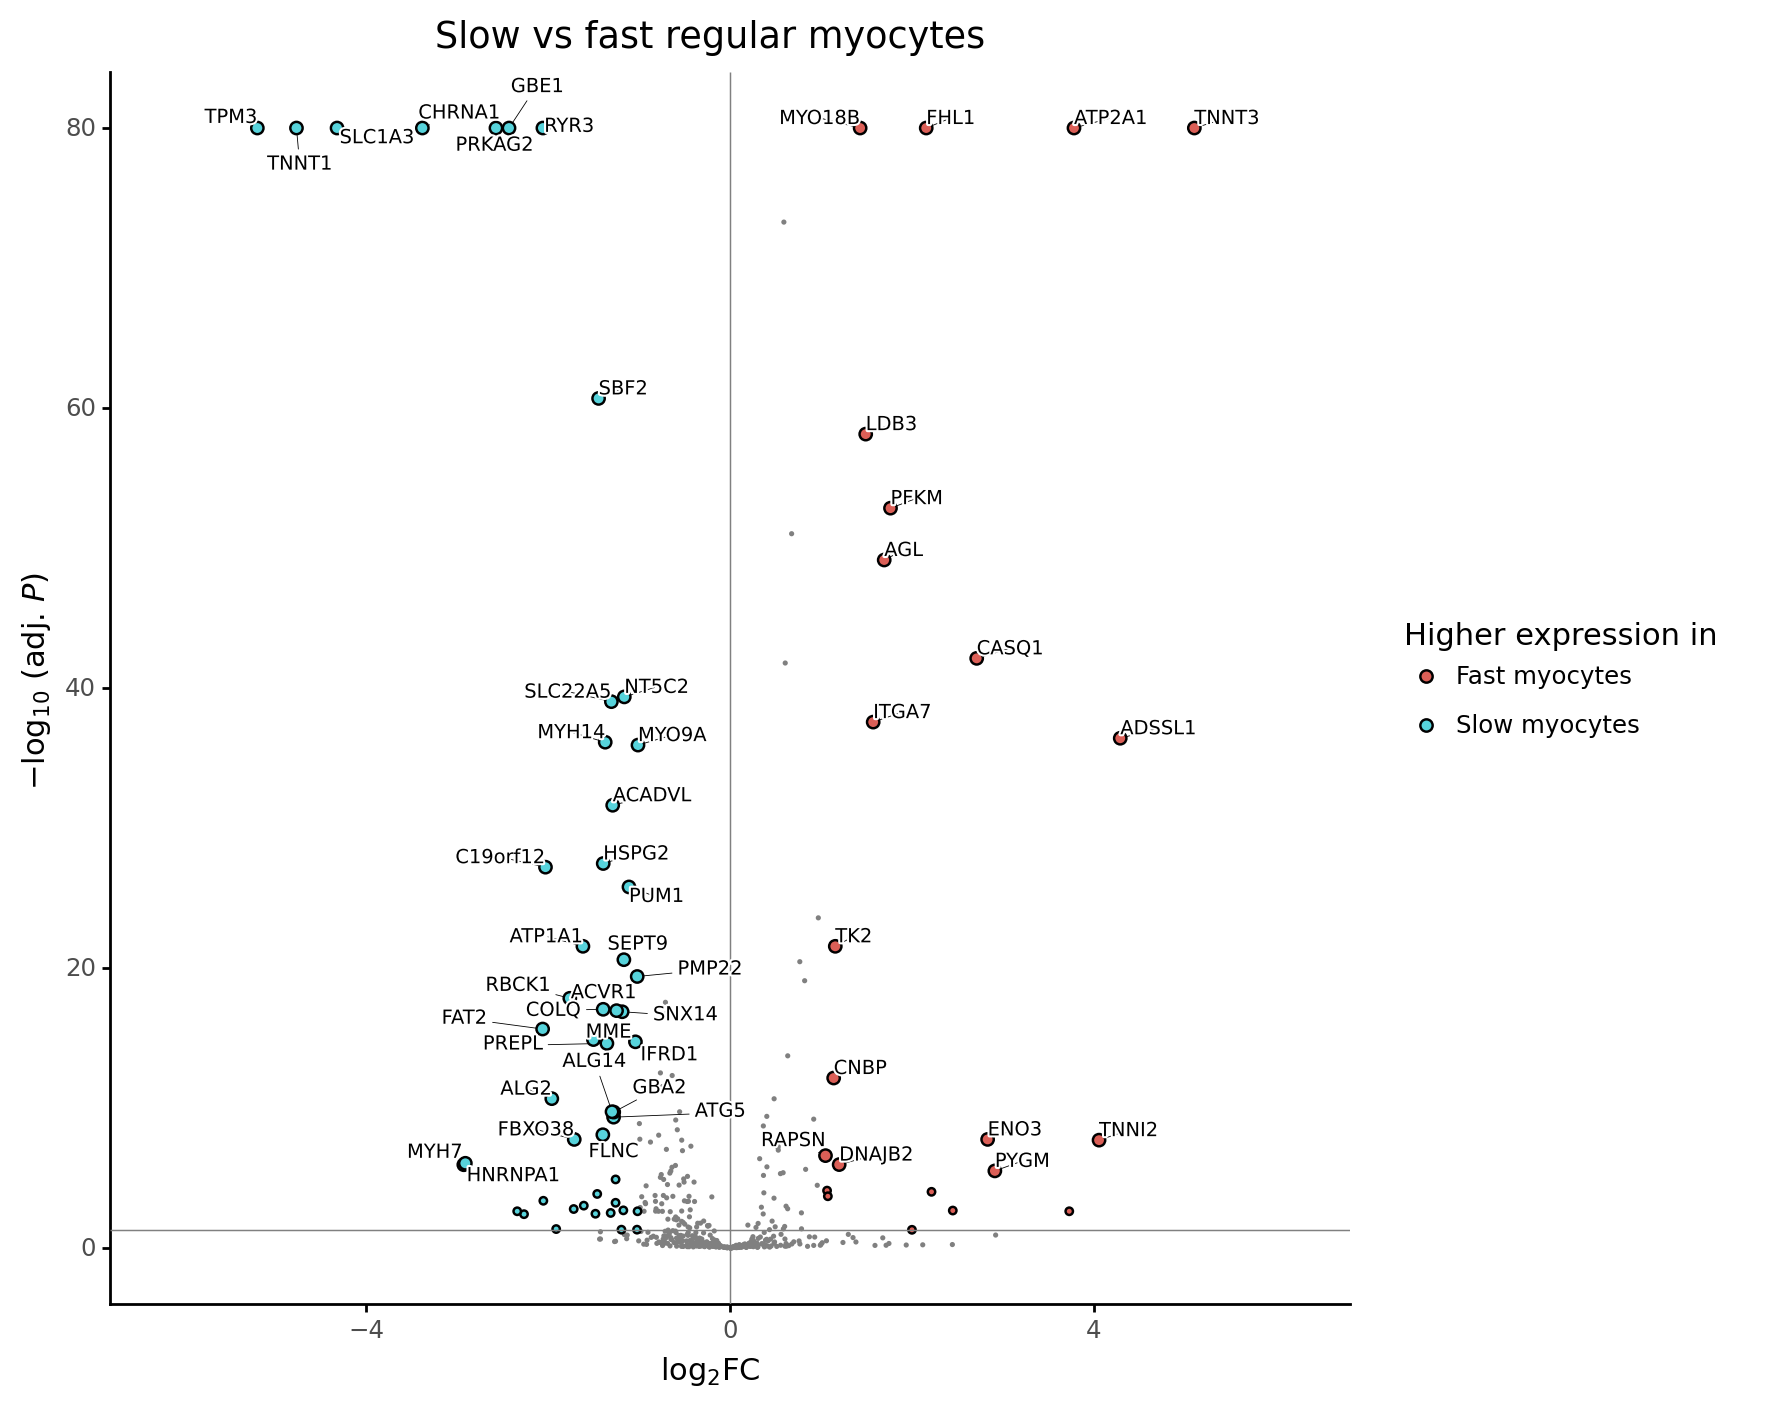

<ggplot: (8743059763905)>

In [386]:
from plotnine import *
import matplotlib.patheffects as pe

df_text_idx = de.significant & (de.neglog_pval_adj>5)
g = (
    ggplot(aes(x='logfoldchanges', y='neglog_pval_adj'), data=de[de.significant]) +     
    geom_point(size=0.05, data=de[(~de.significant)], color='gray') +    
    geom_point(aes(fill='gene_type'), size=1, data=de[de.significant&(~df_text_idx)]) +
    geom_hline(yintercept=(-np.log10(0.05)), size=0.3, color='gray') +    
    geom_vline(xintercept=0, size=0.3, color='gray') +        
    geom_point(aes(fill='gene_type'), color='black', size=2, data=de[de.significant&(df_text_idx)]) +    
    geom_text(aes(label='names'), size=7, color='black', fontweight='normal', data=de[df_text_idx],
              path_effects=[pe.Stroke(linewidth=1.5, foreground='white'),pe.Normal()],
              adjust_text=
              {
                  'arrowprops':{'arrowstyle': '-', 'lw':0.3}, 
                  'x':de[de.significant].logfoldchanges.values, 
                  'y':de[de.significant].neglog_pval_adj.values, 
                  'expand_points': (1,1.5),
              }
    ) + 
    theme_classic() + 
    theme(figure_size=(8,8)) +
    labs(x='$\log_{2}$FC', y='$-\log_{10}$ (adj. $P$)', fill='Higher expression in', title='Slow vs fast regular myocytes') +
    #scale_color_cmapd(values=ad.uns['Tissue_colors']) +
    coord_cartesian(xlim=(-xlimit-1, xlimit+1))+
    guides(color = guide_legend(override_aes = dict(size=5)))
)

ggsave(g, 'figure-slow-vs-fast-D.pdf')

g

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 8 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figure-slow-vs-fast-E.pdf


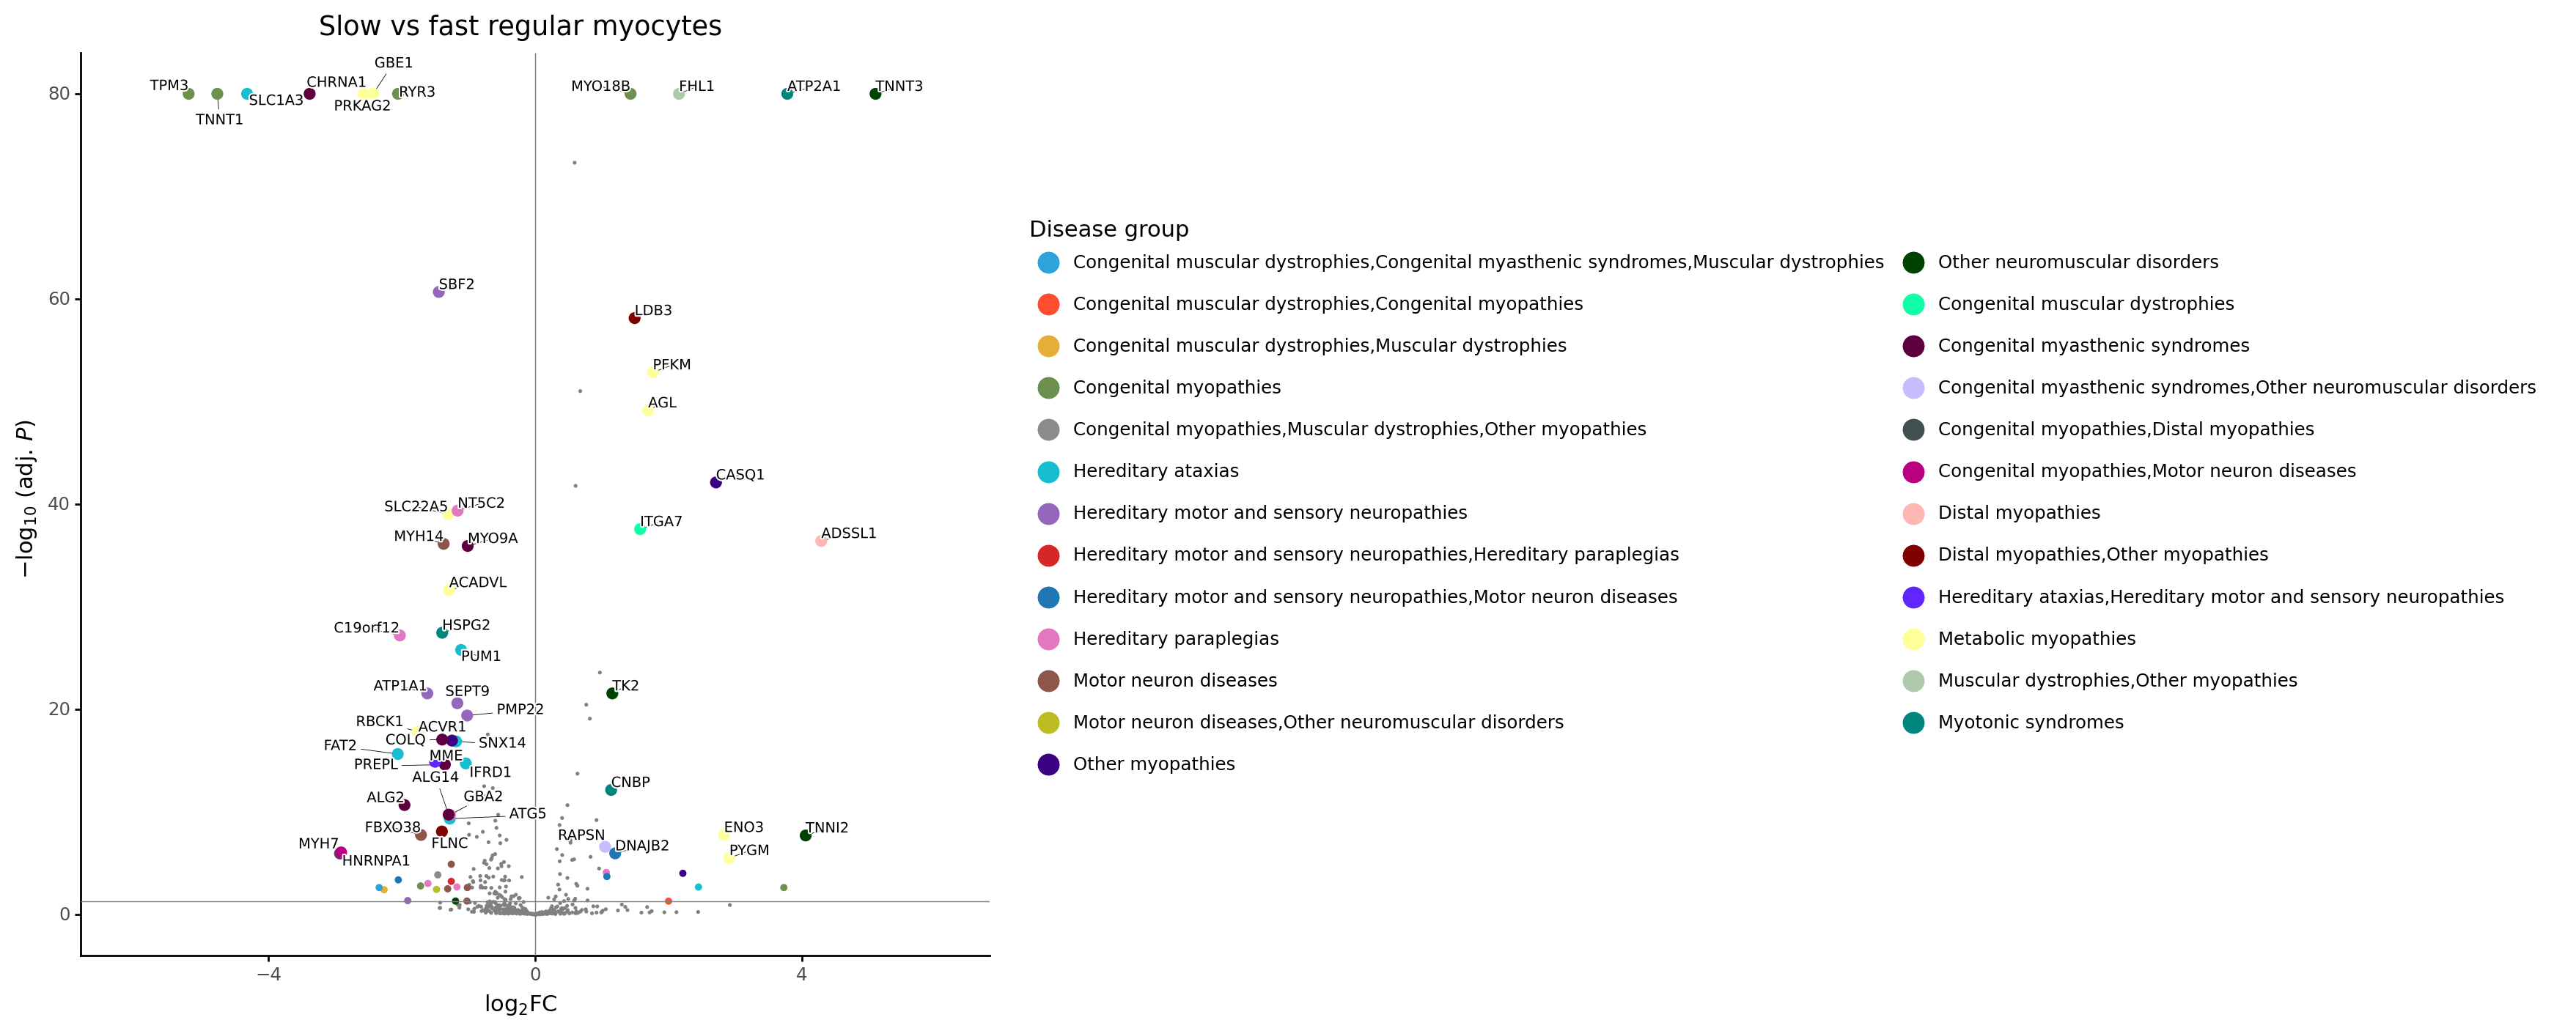

<ggplot: (8743065729642)>

In [387]:
from plotnine import *
import matplotlib.patheffects as pe

df_text_idx = de.significant & (de.neglog_pval_adj>5)
g = (
    ggplot(aes(x='logfoldchanges', y='neglog_pval_adj'), data=de[de.significant]) +     
    geom_point(size=0.05, data=de[(~de.significant)], color='gray') +    
    geom_point(aes(color='disease_group'), size=1, data=de[de.significant&(~df_text_idx)]) +
    geom_hline(yintercept=(-np.log10(0.05)), size=0.3, color='gray') +    
    geom_vline(xintercept=0, size=0.3, color='gray') +        
    geom_point(aes(color='disease_group'), size=2.3, data=de[de.significant&(df_text_idx)]) +    
    geom_text(aes(label='names'), size=7, color='black', fontweight='normal', data=de[df_text_idx],
              path_effects=[pe.Stroke(linewidth=1.5, foreground='white'),pe.Normal()],
              adjust_text=
              {
                  'arrowprops':{'arrowstyle': '-', 'lw':0.3}, 
                  'x':de[de.significant].logfoldchanges.values, 
                  'y':de[de.significant].neglog_pval_adj.values, 
                  'expand_points': (1,1.5),
              }
    ) + 
    theme_classic() + 
    theme(figure_size=(8,8)) +
    scale_color_manual(pal) +    
    labs(x='$\log_{2}$FC', y='$-\log_{10}$ (adj. $P$)', color='Disease group', title='Slow vs fast regular myocytes') +
    #scale_color_cmapd(values=ad.uns['Tissue_colors']) +
    coord_cartesian(xlim=(-xlimit-1, xlimit+1))+
    guides(color = guide_legend(override_aes = dict(size=5)))
)

ggsave(g, 'figure-slow-vs-fast-E.pdf')

g

In [388]:
de = de.merge(myocyte_markers, how='left')

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 8 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figure-slow-vs-fast-F.pdf


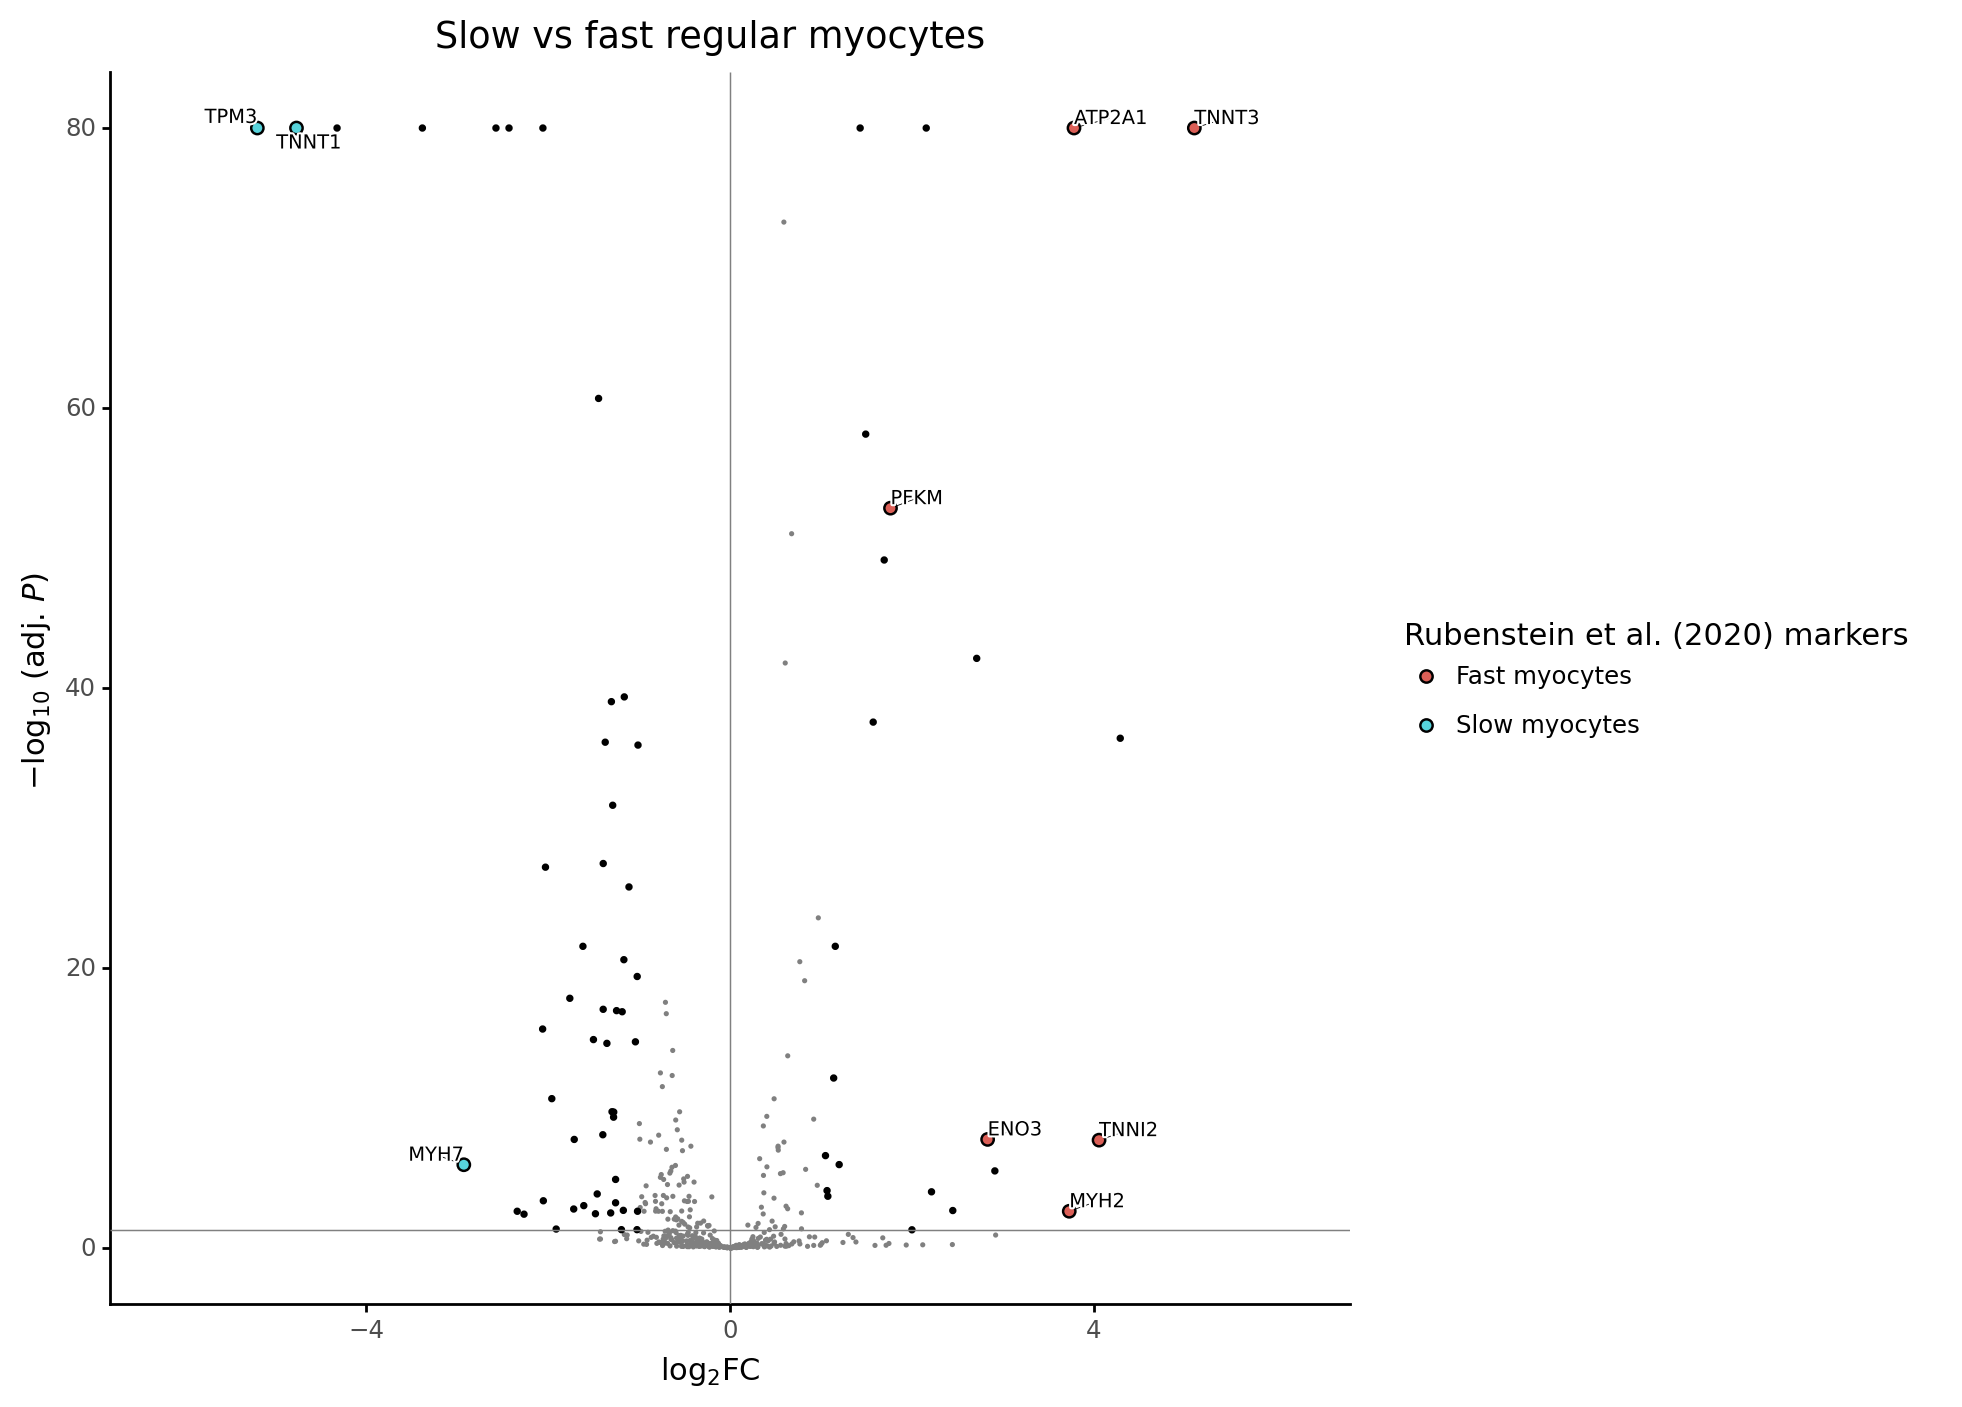

<ggplot: (8743059856978)>

In [389]:
from plotnine import *
import matplotlib.patheffects as pe

df_text_idx = de.significant & (de.marker_group.notna())
g = (
    ggplot(aes(x='logfoldchanges', y='neglog_pval_adj'), data=de[de.significant]) +     
    geom_point(size=0.05, data=de[(~de.significant)], color='gray') +    
    geom_point(size=0.5, data=de[de.significant&(~df_text_idx)]) +
    geom_hline(yintercept=(-np.log10(0.05)), size=0.3, color='gray') +    
    geom_vline(xintercept=0, size=0.3, color='gray') +        
    geom_point(aes(fill='marker_group'), color='black', size=2, data=de[de.significant&(df_text_idx)]) +    
    geom_text(aes(label='names'), size=7, color='black', fontweight='normal', data=de[df_text_idx],
              path_effects=[pe.Stroke(linewidth=1.5, foreground='white'),pe.Normal()],
              adjust_text=
              {
                  'arrowprops':{'arrowstyle': '-', 'lw':0.3}, 
                  'x':de[de.significant].logfoldchanges.values, 
                  'y':de[de.significant].neglog_pval_adj.values, 
                  'expand_points': (1,1.5),
              }
    ) + 
    theme_classic() + 
    theme(figure_size=(8,8)) +
    labs(x='$\log_{2}$FC', y='$-\log_{10}$ (adj. $P$)', fill='Rubenstein et al. (2020) markers', title='Slow vs fast regular myocytes') +
    #scale_color_cmapd(values=ad.uns['Tissue_colors']) +
    coord_cartesian(xlim=(-xlimit-1, xlimit+1))+
    guides(color = guide_legend(override_aes = dict(size=5)))
)

ggsave(g, 'figure-slow-vs-fast-F.pdf')

g